In [12]:
import pandas as pd
import numpy as np
import re
import string
import time
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
from gensim.models import Word2Vec
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Download required NLTK datasets
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/khursheed/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/khursheed/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
reviewPre= pd.read_csv("Reviews.csv")

In [14]:
forSample=reviewPre.drop(['UserId', 'Id','ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Summary'], axis=1)
forSample = forSample.dropna(subset=['Text'])

In [15]:
forSample.head(10)

,ProductId,Score,Text
0,B001E4KFG0,5,I have bought several of the Vitality canned d...
1,B00813GRG4,1,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,4,This is a confection that has been around a fe...
3,B000UA0QIQ,2,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,5,Great taffy at a great price. There was a wid...
5,B006K2ZZ7K,4,I got a wild hair for taffy and ordered this f...
6,B006K2ZZ7K,5,This saltwater taffy had great flavors and was...
7,B006K2ZZ7K,5,This taffy is so good. It is very soft and ch...
8,B000E7L2R4,5,Right now I'm mostly just sprouting this so my...
9,B00171APVA,5,This is a very healthy dog food. Good for thei...


In [16]:
reviewf = forSample.sample(frac=0.345, random_state=42)
reviewf.to_csv('sampled_dataset.csv', index=False)

In [17]:
reviewf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196117 entries, 165256 to 472135
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ProductId  196117 non-null  object
 1   Score      196117 non-null  int64 
 2   Text       196117 non-null  object
dtypes: int64(1), object(2)
memory usage: 6.0+ MB


In [18]:
reviewf.sort_values(by=['ProductId'], inplace=True)

In [19]:
#sentiment label based on the rating score
reviewf['Sentiment'] = reviewf['Score'].apply(lambda x: '1' if x > 3 else '0')
#1 is postive, 0 is negative

In [20]:
reviewf.head(10)

,ProductId,Score,Text,Sentiment
150527,0006641040,3,This book was purchased to be used in a classr...,0
150519,0006641040,5,This book was purchased as a birthday gift for...,1
150511,0006641040,5,I set aside at least an hour each day to read ...,1
150495,0006641040,5,One of my earliest memories is of this book. ...,1
150500,0006641040,5,I can remember seeing the show when it aired o...,1
150498,0006641040,5,This book has been a favorite of mine since I ...,1
150496,0006641040,1,I give five stars to the Maurice Sendak story....,0
150493,0006641040,5,All of my children love this book. My first g...,1
150516,0006641040,5,"Classic children's book, can't go wrong. I rea...",1
150509,0006641040,5,TITLE: Chicken Soup with Rice<br />AUTHOR: Mau...,1


In [21]:
unique_product_count = reviewf['ProductId'].nunique()
print("Number of unique ProductIds:", unique_product_count)

Number of unique ProductIds: 45719


Visualization of data

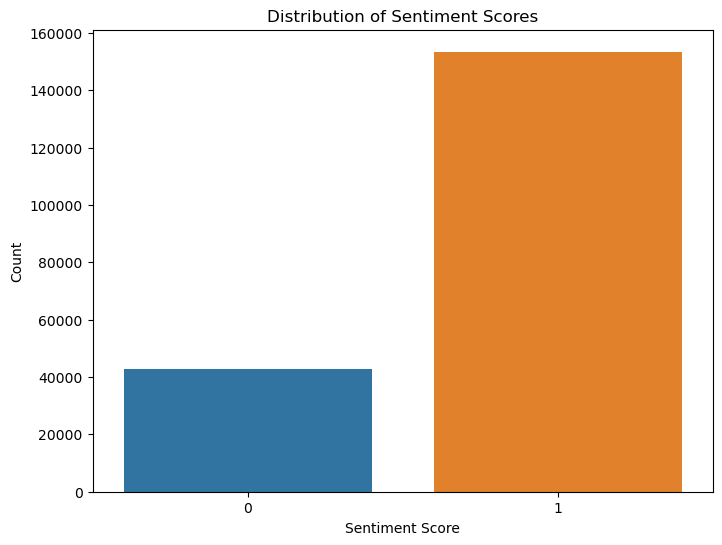

In [22]:
# Plotting the distribution of sentiment scores
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=reviewf)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.show()

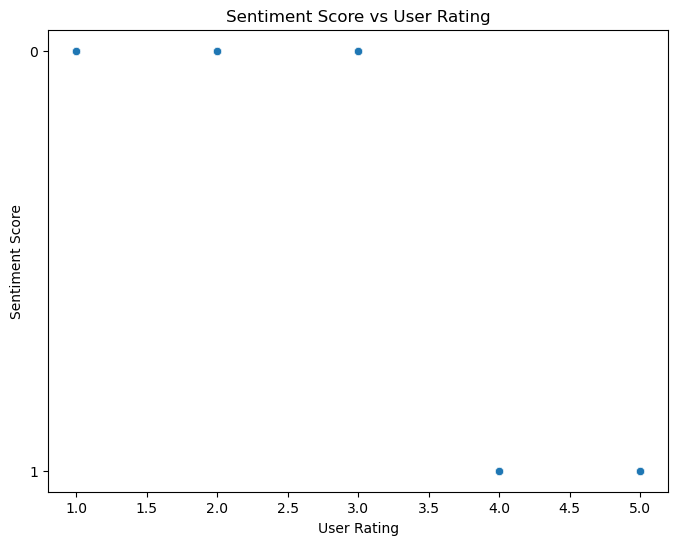

In [23]:
# Scatter plot of sentiment score vs user rating
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Score', y='Sentiment', data=reviewf, alpha=1)
plt.title('Sentiment Score vs User Rating')
plt.xlabel('User Rating')
plt.ylabel('Sentiment Score')
plt.show()

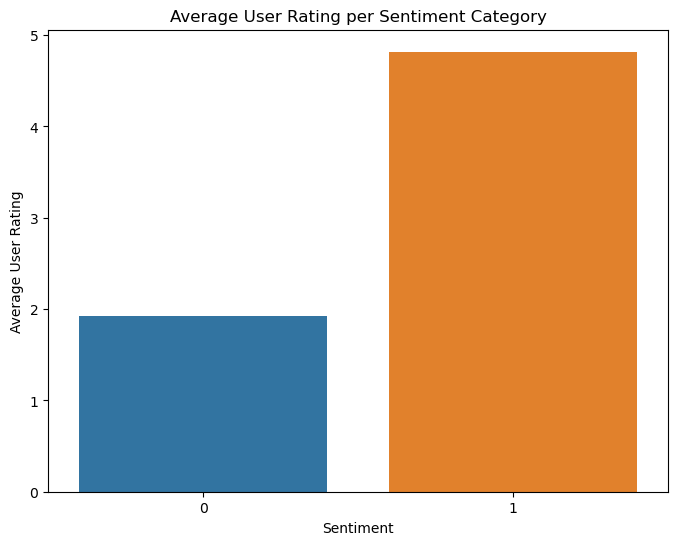

In [24]:
# Plot average user rating per sentiment score
avg_user_rating = reviewf.groupby('Sentiment')['Score'].mean().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(x='Sentiment', y='Score', data=avg_user_rating)
plt.title('Average User Rating per Sentiment Category')
plt.xlabel('Sentiment')
plt.ylabel('Average User Rating')
plt.show()

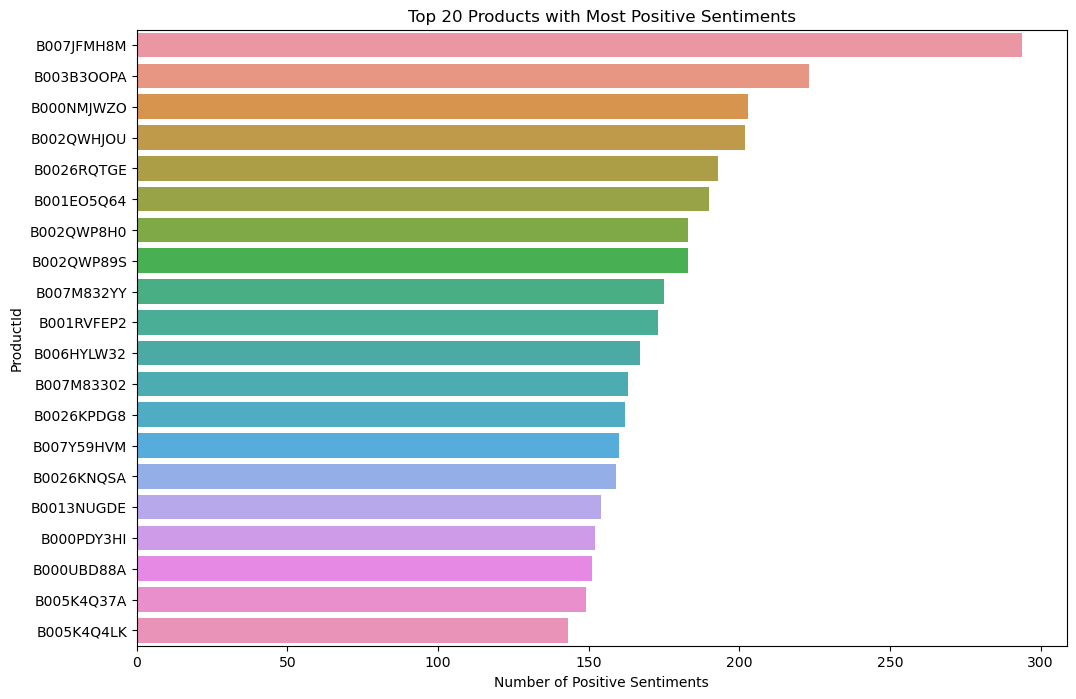

In [25]:
#To display most liked product based on positive sentiment
# Positive sentiments
reviewf['Sentiment'] = reviewf['Sentiment'].astype(int) #type casting
positive_reviews = reviewf[reviewf['Sentiment'] == 1]

# Counting positive sentiments for each ProductId
if not positive_reviews.empty:
    positive_count = positive_reviews.groupby('ProductId').size().reset_index(name='PositiveCount')

# To sort and select the top 20 product ids
    top_n = 20
    top_positive_products = positive_count.sort_values(by='PositiveCount', ascending=False).head(top_n)
else: 
    print("No positive sentiments found in the dataset.")
# Plots
plt.figure(figsize=(12, 8))
sns.barplot(x='PositiveCount', y='ProductId', data=top_positive_products)
plt.title(f'Top {top_n} Products with Most Positive Sentiments')
plt.xlabel('Number of Positive Sentiments')
plt.ylabel('ProductId')
plt.show()

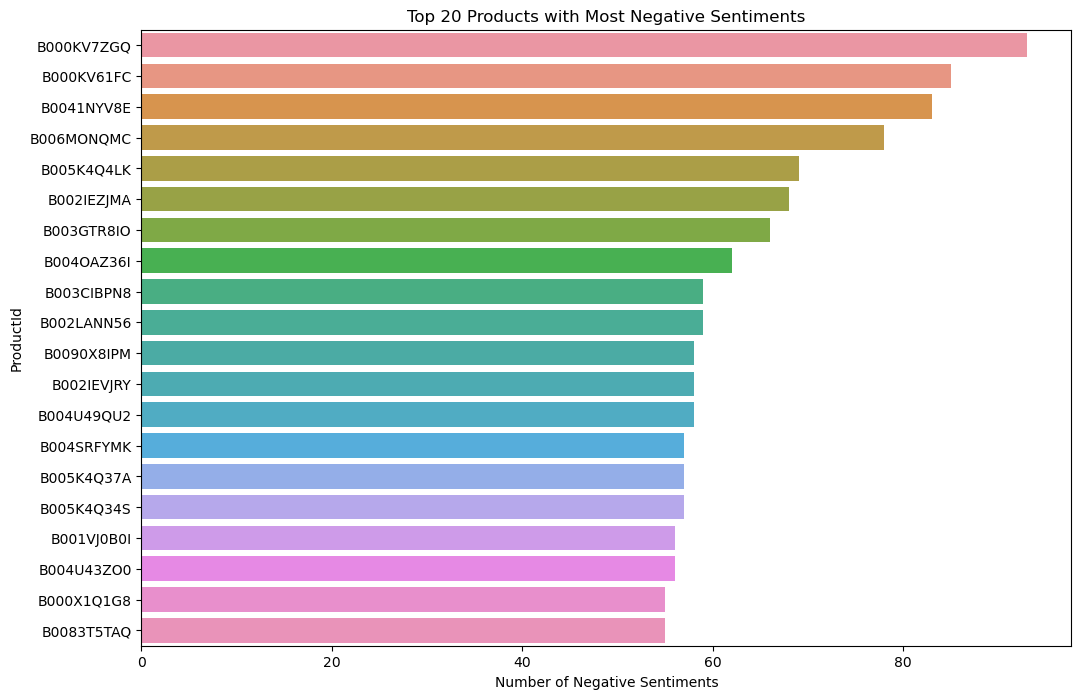

In [26]:
#To display most disliked product based on positive sentiment
# Negative sentiments
reviewf['Sentiment'] = reviewf['Sentiment'].astype(int) #type casting
negative_reviews = reviewf[reviewf['Sentiment'] == 0]

# Counting positive sentiments for each ProductId
n_count = negative_reviews.groupby('ProductId').size().reset_index(name='NegativeCount')
top_n = 20
top_n_products = n_count.sort_values(by='NegativeCount', ascending=False).head(top_n)

plt.figure(figsize=(12, 8))
sns.barplot(x='NegativeCount', y='ProductId', data=top_n_products)
plt.title(f'Top {top_n} Products with Most Negative Sentiments')
plt.xlabel('Number of Negative Sentiments')
plt.ylabel('ProductId')
plt.show()

In [27]:
#Positive reviews outweight negative by 
# Separate the majority and minority classes
df_majority = reviewf[reviewf.Sentiment == 1]
df_minority = reviewf[reviewf.Sentiment == 0]
# Downsampling Positive sentiment class to match Negative sentiment class
df_majority_downsampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=123)
# Combining minority class with downsampled majority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])
# To display class counts, before and after sampling 
print(reviewf.Sentiment.value_counts())
print(df_balanced.Sentiment.value_counts())

1    153402
0     42715
Name: Sentiment, dtype: int64
1    42715
0    42715
Name: Sentiment, dtype: int64


In [28]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Removing HTML tags, punctuation using regex and then tokenize
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    filtered_tokens = [word.lower() for word in tokens if word.lower() not in stop_words and word.isalpha()]
    return filtered_tokens


# Applying  preprocessing to the text column
df_balanced['Processed_Text'] = df_balanced['Text'].apply(preprocess_text)
all_words = [word for tokens in df_balanced['Processed_Text'] for word in tokens] #to compute the word frequencies again
word_freq = Counter(all_words)

# Converting DataFrame for easier analysis and sorting by frequency and display the top words
freq_df = pd.DataFrame(word_freq.items(), columns=['word', 'frequency'])
top_words = freq_df.sort_values(by='frequency', ascending=False).head(10)
print(top_words)

        word  frequency
32      like      41485
17      good      28869
31     taste      28582
117      one      27027
40   product      25626
30    coffee      25182
114   flavor      23000
48     would      22269
29     great      19852
72      food      19812


In [29]:
#2 copies, one for Word2Vec and one for TF-IDF
df_balanced2 = df_balanced.copy() #will be used for TF-IDF

,ProductId,Score,Text,Sentiment,Processed_Text
89218,B0018R0MOI,5,I LOVE this popcorn! I am on a gluten free di...,1,"[love, popcorn, gluten, free, diet, sweet, sna..."
435340,B004JNQMMO,5,Good tasting granola. Seems to be gluten-free...,1,"[good, tasting, granola, seems, glutenfree, ce..."
204347,B006N3I79Y,5,This is a great tasting coffee. It does not ta...,1,"[great, tasting, coffee, taste, like, decaf, f..."


In [30]:
#TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1, 1), min_df=2, max_df=0.8, stop_words='english')

# Fit and transform the 'Text' column
X_tfidf = tfidf_vectorizer.fit_transform(df_balanced2['Text'])

# Converting to dataframe
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
df_balanced2 = pd.concat([df_balanced2.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

In [31]:
# List of TF-IDF feature names
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
print(tfidf_feature_names)

['00' '10' '100' ... 'yummy' 'zero' 'zico']


In [33]:
# Setting parameters for Word2Vec, setting word vector size, the context window size and word threshold; vs, w and mint were set as suggested on website
vs = 100 
w = 5        
mint = 1      

# Training vector model, paramters as above
w2v_model = Word2Vec(sentences=df_balanced['Processed_Text'], vector_size=vs, window=w, min_count=mint)

# vector for one word using our trained model
word_vector = w2v_model.wv['bad']

In [34]:
print(word_vector)

[-0.84248424 -0.5449964  -0.05959362  2.3161383  -0.18576407 -0.5389829
  1.3834782   0.30554977  0.30967054 -0.1632301  -0.6207537   1.254618
  1.5022864   1.1753756  -1.1734011   1.0174811  -1.2868204   0.26674244
 -2.4424732  -2.6500726  -0.5048847   0.38813642 -0.0821401   0.5368322
  1.2421658  -1.035485   -1.2296098   0.88751096  0.33096436  0.06860986
  0.5868278  -1.1503795  -0.678771    0.61749965  0.14775236  1.2304645
  2.0033815   2.4834342  -1.0352434   1.7478837  -1.3209865  -1.1330199
 -2.1707675  -1.8838603   1.2568194   0.1331491  -0.219947    1.7847086
 -1.4621851   1.9201788   1.715653    0.24703154 -0.0558585  -1.088556
 -2.3014755  -1.5007383   1.1069916   0.41857928  2.2057126   1.574575
 -1.8258109  -1.0616175   0.2627978  -2.305236    0.8698048  -0.5395034
 -0.42469552  1.5820329  -0.16492927  0.80618626 -0.5775054   0.5482282
  1.2596751   1.0810913  -1.7352524  -2.7471716  -0.92282385 -0.43399975
 -1.9725562   0.64381754 -0.4624004   2.1715598   1.1838893   1.

In [32]:
#Feature and target matrix for dataframe which is vectorized using TF-IDF
X1 = df_balanced2[tfidf_feature_names]
y1 = df_balanced2['Sentiment']

In [36]:
def document_vector(w2v_model, doc):
    doc = [word for word in doc if word in w2v_model.wv]
    if not doc:
        return np.zeros(vs)
    return np.mean(w2v_model.wv[doc], axis=0)

# Apply the function to each document in the dataframe
df_balanced['Doc_Vector'] = df_balanced['Processed_Text'].apply(lambda x: document_vector(w2v_model, x))

# Prepare the feature matrix X and target vector y
X = np.array(df_balanced['Doc_Vector'].tolist())
y = df_balanced['Sentiment'].values

In [37]:
#X1 and y1 from df_balanced2 which is vectorized using TF-IDF
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.25, random_state=42)

In [38]:
#X and y from df_balanced which is vectorized using Word2Vec
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [39]:
gnb = GaussianNB()
label_encoder = LabelEncoder()
gnb.fit(X1_train, y1_train)
y1_pred = gnb.predict(X1_test)

print("Classification Report:\n", classification_report(y1_test, y1_pred))
print("Accuracy:", accuracy_score(y1_test, y1_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.77     10658
           1       0.76      0.79      0.78     10700

    accuracy                           0.77     21358
   macro avg       0.77      0.77      0.77     21358
weighted avg       0.77      0.77      0.77     21358

Accuracy: 0.770530948590692


In [41]:
mnb = MultinomialNB()
mnb.fit(X1_train, y1_train)

# Predicting using trained model and checking accuracy and classification report
y1_pred = mnb.predict(X1_test)
print("Classification Report:\n", classification_report(y1_test, y1_pred))
accuracy = accuracy_score(y1_test, y1_pred)
print("Accuracy:", accuracy)

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.81      0.82     10658
           1       0.81      0.83      0.82     10700

    accuracy                           0.82     21358
   macro avg       0.82      0.82      0.82     21358
weighted avg       0.82      0.82      0.82     21358

Accuracy: 0.8191310047757281


In [42]:
#Grid Search for MultiNomial NB
#Grid Search Array
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(mnb, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X1_train, y1_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='accuracy', verbose=1)

In [43]:
print("Parameters from GridSearch: ", grid_search.best_params_)
#Predicting and Classification report and accuracy scores
best_mnb = grid_search.best_estimator_
y1_pred = best_mnb.predict(X1_test)
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y1_test, y1_pred))
print("Accuracy:", accuracy_score(y1_test, y1_pred))

Best Parameters:  {'alpha': 10}
              precision    recall  f1-score   support

           0       0.83      0.80      0.82     10658
           1       0.81      0.84      0.82     10700

    accuracy                           0.82     21358
   macro avg       0.82      0.82      0.82     21358
weighted avg       0.82      0.82      0.82     21358

Accuracy: 0.820161063770016


In [44]:
default_logreg = LogisticRegression(random_state=42)
default_logreg.fit(X1_train, y1_train)
# Evaluating default model
y1_pred_default = default_logreg.predict(X1_test)
accuracy_default = accuracy_score(y1_test, y1_pred_default)
print("Default Model Accuracy:", accuracy_default)
from sklearn.metrics import roc_auc_score
y1_test_bin = label_binarize(y1_test, classes=np.unique(y1_train))
y1_pred_proba_default = default_logreg.predict_proba(X1_test)

Default Model Accuracy: 0.8391703343009645


In [119]:
print(classification_report(y1_test, y1_pred_default))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84     10658
           1       0.84      0.84      0.84     10700

    accuracy                           0.84     21358
   macro avg       0.84      0.84      0.84     21358
weighted avg       0.84      0.84      0.84     21358



In [45]:
y1_pred_proba_default = default_logreg.predict_proba(X1_test)[:, 1]
roc_auc_default = roc_auc_score(y1_test, y1_pred_proba_default)

print("Default Model ROC AUC Score:", roc_auc_default)

Default Model ROC AUC Score: 0.9161581138647115


In [ ]:
param_grid_logreg = {
    'C': [0.01, 0.1, 1, 10],
    'max_iter': [1000, 2000, 3000, 5000]
}

#GridSearchCV with Logistic Regression
grid_search_logreg = GridSearchCV(LogisticRegression(random_state=42), param_grid_logreg, cv=3, scoring='accuracy', verbose=1)
grid_search_logreg.fit(X1_train, y1_train)
best_params = grid_search_logreg.best_params_
print("Best parameters for Logistic Regression: ", best_params)

In [118]:
#optimized_logreg = LogisticRegression(C=best_params['C'], max_iter=best_params['max_iter'],multi_class='ovr', random_state=42)
optimized_logreg = LogisticRegression(C=1, max_iter=1000,multi_class='ovr', random_state=42)

optimized_logreg.fit(X1_train, y1_train)
y1_pred_optimized = optimized_logreg.predict(X1_test)
accuracy_optimized = accuracy_score(y1_test, y1_pred_optimized)
print("Optimized Model Accuracy:", accuracy_optimized)
print(classification_report(y1_test, y1_pred_optimized))

Optimized Model Accuracy: 0.8391703343009645
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     10658
           1       0.84      0.84      0.84     10700

    accuracy                           0.84     21358
   macro avg       0.84      0.84      0.84     21358
weighted avg       0.84      0.84      0.84     21358



In [47]:
y1_pred_proba_optimized = optimized_logreg.predict_proba(X1_test)[:, 1]
roc_auc_default = roc_auc_score(y1_test, y1_pred_proba_optimized)
print("Optimized Model ROC AUC Score:", roc_auc_default)

Optimized Model ROC AUC Score: 0.9161581138647115


In [48]:
linear_svm = LinearSVC(C=1, random_state=42)
linear_svm.fit(X1_train, y1_train)
y1_pred_linear = linear_svm.predict(X1_test)
accuracy_linear = accuracy_score(y1_test, y1_pred_linear)
print("Accuracy of Linear SVM model:", accuracy_linear)
print(classification_report(y1_test, y1_pred_linear))

/Users/khursheed/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy of Linear SVM model: 0.8394044386178481
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     10658
           1       0.84      0.84      0.84     10700

    accuracy                           0.84     21358
   macro avg       0.84      0.84      0.84     21358
weighted avg       0.84      0.84      0.84     21358



In [49]:
param_grid_linear_svm = {
    'C': [0.01, 0.1, 1, 10, 100] 
}
grid_search_linear_svm = GridSearchCV(LinearSVC(random_state=42), param_grid_linear_svm, cv=3, scoring='accuracy', verbose=1)
grid_search_linear_svm.fit(X1_train, y1_train)
print("Best parameters for Linear SVM: ", grid_search_linear_svm.best_params_)
optimized_linear_svm = LinearSVC(**grid_search_linear_svm.best_params_, random_state=42)
optimized_linear_svm.fit(X1_train, y1_train)
y1_pred_optimized = optimized_linear_svm.predict(X1_test)
accuracy_optimized = accuracy_score(y1_test, y1_pred_optimized)
print("Accuracy of Optimized Linear SVM model:", accuracy_optimized)
print(classification_report(y1_test, y1_pred_optimized))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/Users/khursheed/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khursheed/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khursheed/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khursheed/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/k

Best parameters for Linear SVM:  {'C': 0.1}


/Users/khursheed/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy of Optimized Linear SVM model: 0.8389830508474576
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     10658
           1       0.84      0.84      0.84     10700

    accuracy                           0.84     21358
   macro avg       0.84      0.84      0.84     21358
weighted avg       0.84      0.84      0.84     21358



In [ ]:
svm_poly = SVC(C=1, kernel='poly', random_state=42)
svm_poly.fit(X1_train, y1_train)
y1_pred_poly = svm_poly.predict(X1_test)
accuracy_poly = accuracy_score(y1_test, y1_pred_poly)
print("Accuracy of SVM model with polynomial kernel:", accuracy_poly)
print(classification_report(y1_test, y1_pred_poly))

In [50]:
# Default Decision Tree Model
dt_default = DecisionTreeClassifier()
dt_default.fit(X1_train, y1_train)  
y_pred_dt = dt_default.predict(X1_test)

In [51]:
accuracy_dt = accuracy_score(y1_test, y_pred_dt)
print("Decision Tree Accuracy:", accuracy_dt)
print(classification_report(y1_test, y_pred_dt))

Decision Tree Accuracy: 0.7534881543215657
              precision    recall  f1-score   support

           0       0.75      0.76      0.76     10658
           1       0.76      0.74      0.75     10700

    accuracy                           0.75     21358
   macro avg       0.75      0.75      0.75     21358
weighted avg       0.75      0.75      0.75     21358



In [ ]:
param_grid_dt = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5, scoring='accuracy')
grid_search_dt.fit(X1_train, y1_train)
print("Best parameters for Decision Tree:", grid_search_dt.best_params_)

In [61]:
dt_optimized = DecisionTreeClassifier(min_samples_split=2, max_depth=10, min_samples_leaf=4)
dt_optimized.fit(X1_train, y1_train)  
y_pred_optimized_dt = dt_default.predict(X1_test)

In [62]:
accuracy_optimized_dt = accuracy_score(y_test, y_pred_optimized_dt)
print("Optimized Decision Tree Accuracy:", accuracy_optimized_dt)

Optimized Decision Tree Accuracy: 0.7534881543215657


In [ ]:
Random Forest

In [63]:
rf_default = RandomForestClassifier(random_state=42)
rf_default.fit(X_train, y_train)
y_pred_rf = rf_default.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)

Random Forest Accuracy: 0.8175390954209195


In [64]:
print(classification_report(y1_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.81      0.82      0.82     10658
           1       0.82      0.81      0.82     10700

    accuracy                           0.82     21358
   macro avg       0.82      0.82      0.82     21358
weighted avg       0.82      0.82      0.82     21358



In [ ]:
Gradient Boosting Machine

In [65]:
# Creating the XGBoost classifier using xgb import
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("Gradient Boosting Machine Accuracy:", accuracy_xgb)
print(classification_report(y_test, y_pred_xgb))

Gradient Boosting Machine Accuracy: 0.8126229047663639
              precision    recall  f1-score   support

           0       0.81      0.82      0.81     10658
           1       0.82      0.80      0.81     10700

    accuracy                           0.81     21358
   macro avg       0.81      0.81      0.81     21358
weighted avg       0.81      0.81      0.81     21358



In [66]:
model_rnn_w2v = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_rnn_w2v.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model_rnn_w2v.fit(X_train, y_train, epochs=5, validation_split=0.2)
y_pred = model_rnn_w2v.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int).flatten()
accuracy = accuracy_score(y_test, y_pred_binary)
print("Model Accuracy:", accuracy)
print(classification_report(y_test,y_pred_binary))

Epoch 1/5
1602/1602 [==============================] - 1s 576us/step - loss: 0.4620 - accuracy: 0.7820 - val_loss: 0.4438 - val_accuracy: 0.7927
Epoch 2/5
1602/1602 [==============================] - 1s 515us/step - loss: 0.4283 - accuracy: 0.8030 - val_loss: 0.4364 - val_accuracy: 0.7959
Epoch 3/5
1602/1602 [==============================] - 1s 509us/step - loss: 0.4168 - accuracy: 0.8070 - val_loss: 0.4242 - val_accuracy: 0.8041
Epoch 4/5
1602/1602 [==============================] - 1s 514us/step - loss: 0.4089 - accuracy: 0.8121 - val_loss: 0.4256 - val_accuracy: 0.8017
Epoch 5/5
668/668 [==============================] - 0s 254us/step
Model Accuracy: 0.808081281018822
              precision    recall  f1-score   support

           0       0.81      0.81      0.81     10658
           1       0.81      0.81      0.81     10700

    accuracy                           0.81     21358
   macro avg       0.81      0.81      0.81     21358
weighted avg       0.81      0.81      0.81    

In [69]:
#Defining function for a string which we can use to cross validate if our model is working
def string_to_w2v_vector(input_string, word2vec_model):
    words = preprocess_text(input_string)  
    word_vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]

    if len(word_vectors) > 0:
        document_vector = np.mean(word_vectors, axis=0)
    else:
        document_vector = np.zeros(vs) 
    
    return document_vector.reshape(1, -1)  

In [70]:
def predict_sentiment(input_string, model, word2vec_model):
    #to convert it to vector document which can be utilised 
    vectorized_input = string_to_w2v_vector(input_string, word2vec_model)
    
    # Make a prediction
    prediction = model.predict(vectorized_input)
    
    # Interpret the prediction
    #sentiment = "positive" if prediction[0][0] > 0.5 else "negative"
    #return sentiment
    return prediction

In [76]:
def predict_sentiment2(input_string, model, word2vec_model):
    #to convert it to vector document which can be utilised 
    vectorized_input = string_to_w2v_vector(input_string, word2vec_model)
    
    # Make a prediction
    prediction = model.predict(vectorized_input)
    
    # Interpret the prediction, using this for RNN model
    sentiment = "positive" if prediction[0][0] > 0.5 else "negative"
    return sentiment
    #return prediction

In [71]:
input_string = "This product is so good, I love it! it can be better but"
predicted_sentiment = predict_sentiment(input_string,xgb_clf, w2v_model)
print("Predicted sentiment:", predicted_sentiment)

Predicted sentiment: [1]


In [72]:
input_string = "I cannot say how bad it is, cannot think how something could be this unfunctional"
predicted_sentiment = predict_sentiment(input_string,xgb_clf, w2v_model)
print("Predicted sentiment:", predicted_sentiment)

Predicted sentiment: [0]


In [73]:
input_string = "Don't recommened."
predicted_sentiment = predict_sentiment(input_string,xgb_clf, w2v_model)
print("Predicted sentiment:", predicted_sentiment)

Predicted sentiment: [0]


In [77]:
input_string = "I cannot say how bad it is, cannot think how something could be this unfunctional"
predicted_sentiment = predict_sentiment2(input_string,model_rnn_w2v, w2v_model)
print("Predicted sentiment:", predicted_sentiment)

1/1 [==============================] - 0s 7ms/step
Predicted sentiment: negative


In [78]:
input_string = "Don't recommened."
predicted_sentiment = predict_sentiment2(input_string,model_rnn_w2v, w2v_model)
print("Predicted sentiment:", predicted_sentiment)

1/1 [==============================] - 0s 6ms/step
Predicted sentiment: negative


In [79]:
input_string = "This product is so good I love it"
predicted_sentiment = predict_sentiment2(input_string, model_rnn_w2v, w2v_model)
print("Predicted sentiment:", predicted_sentiment)


1/1 [==============================] - 0s 9ms/step
Predicted sentiment: positive


In [68]:
models = {
    'Naive Bayes (Default)':gnb,
    'Multinomial Naive Bayes (Default)':mnb,
    'Multinomial Naive Bayes (Optimized)':best_mnb,
    'Linear Regression (Default)':default_logreg,
    'Linear Regression (Optimized)':optimized_logreg,
    'Linear SVM (Default)': linear_svm,
    'Linear SVM (Optimized)': optimized_linear_svm,
    'Random Forest (Default)': rf_default,
    'Gradient Boosting Machine': xgb_clf,
    
}
n_folds = 5
cv_scores = {}

for name, model in models.items():
    scores = cross_val_score(model, X1, y1, cv=n_folds, scoring='accuracy')
    cv_scores[name] = scores
for name, scores in cv_scores.items():
    print(f"{name}: Mean accuracy={scores.mean():.2f} Std={scores.std():.2f}")

/Users/khursheed/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khursheed/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khursheed/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khursheed/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/k

Naive Bayes (Default): Mean accuracy=0.75 Std=0.01
Multinomial Naive Bayes (Default): Mean accuracy=0.80 Std=0.01
Multinomial Naive Bayes (Optimized): Mean accuracy=0.80 Std=0.01
Linear Regression (Default): Mean accuracy=0.83 Std=0.01
Linear Regression (Optimized): Mean accuracy=0.83 Std=0.01
Linear SVM (Default): Mean accuracy=0.83 Std=0.01
Linear SVM (Optimized): Mean accuracy=0.83 Std=0.01
Random Forest (Default): Mean accuracy=0.83 Std=0.01
Gradient Boosting Machine: Mean accuracy=0.82 Std=0.00


In [102]:
def predict_sentiment3(input_string, model, word2vec_model):
    vectorized_input = string_to_w2v_vector(input_string, word2vec_model)

    # To reeshape the vector to be 2D (1, number_of_features), since RNN models expects 2d array (from error logs I got), then make prediction using rnn model (which will be taken from parameter of function)
    vectorized_input_2d = np.reshape(vectorized_input, (1, -1))
    prediction = model.predict(vectorized_input_2d)
    
    # Interpret the prediction
    sentiment = "Positive" if prediction[0][0] > 0.5 else "Negative"
    return sentiment

In [103]:
from nltk.tokenize import sent_tokenize
def extract_pros_and_cons(review, model, word2vec_model):
    sentences = sent_tokenize(review) #splitting the review into sentences, which will be used for pros and cons
    
    pros = [] #two empty arrays for pros and cons
    cons = []

    for sentence in sentences:
        # Predicts the sentiment of the sentence, using our defined function from above, predict_sentiment3. this returns a 2d array
        sentiment = predict_sentiment3(sentence, model, word2vec_model)

        #categorizing sentiment, if positive added to pros and negative added to cons
        if sentiment == "Positive":
            pros.append(sentence)
        else:
            cons.append(sentence)

    return pros, cons

# First example
review_example = "The product quality is outstanding. However, it is quite expensive."
#review_example2="The product is so bad, but I cannot live without it, so I like it!"

# Extract pros and cons and then print the pros and cons
pros, cons = extract_pros_and_cons(review_example, model_rnn_w2v, w2v_model)
print("Pros:")
for pro in pros:
    print("-", pro)

print("\nCons:")
for con in cons:
    print("-", con)

1/1 [==============================] - 0s 6ms/step
Pros:
- The product quality is outstanding.

Cons:
- However, it is quite expensive.


In [105]:
review_example2="The product is so bad. but I cannot live without it so I like it!"
pros, cons = extract_pros_and_cons(review_example2, model_rnn_w2v, w2v_model)
print("Pros:")
for pro in pros:
    print("-", pro)
print("\nCons:")
for con in cons:
    print("-", con)

1/1 [==============================] - 0s 6ms/step
Pros:
- but I cannot live without it so I like it!

Cons:
- The product is so bad.


In [106]:
review_example3 = "I love it. Recommend it "
pros, cons = extract_pros_and_cons(review_example3, model_rnn_w2v, w2v_model)
print("Pros:")
for pro in pros:
    print("-", pro)
print("\nCons:")
for con in cons:
    print("-", con)

1/1 [==============================] - 0s 7ms/step
Pros:
- I love it.
- Recommend it

Cons:


In [110]:
review_example4="Simply awful. This product should be taken off the market immediately.  They did absolutely nothing for my 2-yr old dog's teeth.  I gave him about 4 per week until he almost choked to death on about the 10th one.  Awful, dangerous product, simple as that."
pros, cons = extract_pros_and_cons(review_example4, model_rnn_w2v, w2v_model)
print("Pros:")
for pro in pros:
    print("-", pro)
print("\nCons:")
for con in cons:
    print("-", con)

1/1 [==============================] - 0s 6ms/step
Pros:

Cons:
- Simply awful.
- This product should be taken off the market immediately.
- They did absolutely nothing for my 2-yr old dog's teeth.
- I gave him about 4 per week until he almost choked to death on about the 10th one.
- Awful, dangerous product, simple as that.


In [113]:
review_example5="This is THE best red curry.  Mix with cocunut milk and real palm sugar + chicken and veggies and you will amaze your friend and families.  This is great red curry paste!"
pros, cons = extract_pros_and_cons(review_example5, model_rnn_w2v, w2v_model)
print("Pros:")
for pro in pros:
    print("-", pro)
print("\nCons:")
for con in cons:
    print("-", con)

1/1 [==============================] - 0s 6ms/step
Pros:
- This is THE best red curry.
- Mix with cocunut milk and real palm sugar + chicken and veggies and you will amaze your friend and families.
- This is great red curry paste!

Cons:


In [115]:
review_example6="We love Crystal Light Fruit Punch.  Granted, this is a LARGE amount of punch but works great when mixed in a very large container.  Expensive for its price."
pros, cons = extract_pros_and_cons(review_example6, model_rnn_w2v, w2v_model)
print("Pros:")
for pro in pros:
    print("-", pro)
print("\nCons:")
for con in cons:
    print("-", con)

1/1 [==============================] - 0s 8ms/step
Pros:
- We love Crystal Light Fruit Punch.
- Granted, this is a LARGE amount of punch but works great when mixed in a very large container.

Cons:
- Expensive for its price.
